In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import cftime
import pandas as pd
from datetime import datetime
import matplotlib.colors as mcolors
from scipy.stats import linregress
from eofs.xarray import Eof
from eofs.examples import example_data_path

In [7]:
#getting the correct calendar (model dependent.)
def get_time_bounds(calendar_type, start, end):
    #1850-2015 all of 2014 - none of 2015.
    if calendar_type == cftime.DatetimeNoLeap:
        return cftime.DatetimeNoLeap(start,1,16), cftime.DatetimeNoLeap(end,1,16)
    elif calendar_type == cftime.Datetime360Day:
        return cftime.Datetime360Day(start,1,16), cftime.Datetime360Day(end-1,12,16)
    else:
        return datetime(start,1,16), datetime(end,1,16)

#finding all the models that have ensembles for that experiment.
def get_models_for_experiment(experiment):
    if experiment == 'historical':
        model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    elif experiment == 'hist-aer':
        model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','CNRM-CM6-1','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    elif experiment == 'hist-GHG':
        model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','CNRM-CM6-1','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    elif experiment == 'hist-sol':
        model = ['ACCESS-ESM1-5','CanESM5','GISS-E2-1-G','HadGEM3-GC31-LL','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    elif experiment == 'hist-totalO3':
        model = ['CanESM5','GISS-E2-1-G','HadGEM3-GC31-LL','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    elif experiment == 'hist-volc':
        model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','GISS-E2-1-G','HadGEM3-GC31-LL','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
        
    return model

#Cropping CVDP data to the North Atlantic sector - requires some shifting of 0 of the lat lon coordinate system.
def CVDP_EM_crop_NA_sector(filename, pattern):
    #function which will crop the historical ensemble mean CVDP output to the NA sector
    ds = xr.open_dataset(filename)
    ds = ds[pattern]
    
    #finding the longitudes that are greater than 180
    new_lon = np.where(ds.lon > 179, ds.lon -360, ds.lon)
    
    #creating a copy of the data array where the longitudes have been shifted
    ds_shifted = ds.copy()
    ds_shifted.coords['lon'] = new_lon
    
    #Now need to make sure they are in the correct order and then re-index to make sure the lon get put to match the sorted lon
    sorted_lon = np.sort(ds_shifted.lon)
    ds_shifted = ds_shifted.sel(lon=sorted_lon)
    
    historical_NAO_EM_shifted = ds_shifted.sel(lat=slice(20,80), lon=slice(-90,40))

    return historical_NAO_EM_shifted

#Crops to the North Atlantic sector - for the LESFMIP data NOT processed by CVDP
def open_cropNA_unitshPA(filename):
    #function to crop an ensemble member to the north atlantic region
    data = xr.open_dataset(filename)
    data_NA = data.sel(lat=slice(20,80), lon=slice(-90,40))/100

    return data_NA

In [8]:
#calculating the seasonal and annual ensemble spatial means.

def calculate_spatial_ensemble_mean(file_paths, output_file, variable):
    #Will be passing through an experiment's model's ensembles.
    #opens all the files given by filepath (basically opens all the ensembles)
    ds = xr.open_mfdataset(file_paths, combine='nested', concat_dim='ensemble')

    #calculate the mean
    mean = ds[variable].mean(dim='ensemble')

    #save the ensemble mean to the a .nc file
    mean.to_netcdf(output_file)
    print('saved')

    ds.close()
    return mean

def calculate_seasonal_spatial_ensemble_mean_djf(file_path, var, seas, output_file, year_init, year_final):
    #opening dataset
    print('in function')
    ds = xr.open_dataset(file_path)
    
    #checking it is a datetime object
    ds['time'] = xr.decode_cf(ds).time

    calendar = type(ds.time.values[0])
    
    start,end = get_time_bounds(calendar, year_init, year_final)

    #selecting the psl variable within time bounds
    variable = ds[var].sel(time=slice(start, end))
    
    #Filter for the desired season (e.g., DJF)
    season_mask = variable.time.dt.season == seas
    ds_months_seas = variable.sel(time=season_mask)
    
    #assign and adjust year (DJF split over two years so increasing the year of december and then grouping and finding the mean)
    ds_months_seas = ds_months_seas.assign_coords(year=ds_months_seas['time'].dt.year)
    ds_months_seas['year'] = ds_months_seas['year'].where(ds_months_seas['time'].dt.month != 12, ds_months_seas['year'] + 1)
    #ds_months_seas = ds_months_seas.set_coords('year')
    
    # average over DJF months for each year
    ds_season = ds_months_seas.groupby('year').mean(dim='time')
    ds_season.to_netcdf(output_file)
    print('saved file')
    return ds_season

In [9]:
#functions defined for calculating the linear trend
def calculate_linear_trend_spat_pattern(file_path, variable, output_file):
    # Open dataset and extract variable
    ds = xr.open_dataset(file_path)
    da = ds[variable]

    time = ds['year'].values
    lat = ds['lat'].values
    lon = ds['lon'].values
    time_numeric = np.arange(len(time))

    slope = np.full((len(lat), len(lon)), np.nan)
    intercept = np.full((len(lat), len(lon)), np.nan)
    p_value = np.full((len(lat), len(lon)), np.nan)
    stderr = np.full((len(lat), len(lon)), np.nan)

    for i in range(len(lat)):
        for j in range(len(lon)):
            ts = da[:, i, j].values
            if np.all(np.isfinite(ts)):
                reg = linregress(time_numeric, ts)
                slope[i, j] = reg.slope
                intercept[i, j] = reg.intercept
                p_value[i, j] = reg.pvalue
                stderr[i, j] = reg.stderr

    from scipy.stats import t
    n = len(time_numeric)
    df = n - 2
    alpha = 0.05
    t_crit = t.ppf(1 - alpha/2, df)

    ci_lower = slope - t_crit * stderr
    ci_upper = slope + t_crit * stderr

    slope_da = xr.DataArray(slope, coords=[lat, lon], dims=["lat", "lon"], name="slope")
    intercept_da = xr.DataArray(intercept, coords=[lat, lon], dims=["lat", "lon"], name="intercept")
    p_value_da = xr.DataArray(p_value, coords=[lat, lon], dims=["lat", "lon"], name="p_value")
    ci_lower_da = xr.DataArray(ci_lower, coords=[lat, lon], dims=["lat", "lon"], name="slope_CI_lower")
    ci_upper_da = xr.DataArray(ci_upper, coords=[lat, lon], dims=["lat", "lon"], name="slope_CI_upper")

    # Save to one combined netCDF file
    combined_ds = xr.Dataset({
        "slope": slope_da,
        "intercept": intercept_da,
        "p_value": p_value_da,
        "slope_CI_lower": ci_lower_da,
        "slope_CI_upper": ci_upper_da
    })
    combined_ds.to_netcdf(output_file)





In [38]:
def calculate_regression_map(anomalies, mode, e, m, period, individual=False):
    # select mode number
    mode_number = 0 if mode == 'NAO' else 1

    # preprocess anomalies
    anomaly_list = [open_cropNA_unitshPA(f) for f in anomalies]

    if individual:
        for i, da in enumerate(anomaly_list):
            print('calculating the individual ensembles')
            psl = da['psl']
            wgts = np.sqrt(np.cos(np.deg2rad(psl.coords['lat'].values)))[..., np.newaxis]
            psl_stacked = psl.rename({'year': 'time'}).transpose('time', 'lat', 'lon')

            solver = Eof(psl_stacked, weights=wgts)
            EOF_pattern = solver.eofs(neofs=mode_number+1).sel(mode=mode_number)
            pc = solver.pcs(npcs=mode_number+1, pcscaling=1).sel(mode=mode_number)
            regression_map = (psl_stacked * pc).mean(dim='time')

            # Sign convention correction
            #ensures Icelandic Low is negative and EA main centre is also negative.
            if mode == 'NAO':

                if regression_map.sel(lat=50, lon=-30, method='nearest') > 0 and \
                   regression_map.sel(lat=35, lon=-15, method='nearest') < 0:
                    regression_map *= -1
                    pc *= -1

            elif mode == 'EA':
 
                if regression_map.sel(lat=50, lon=-25, method='nearest') > 0 and \
                   regression_map.sel(lat=30, lon=0, method='nearest') < 0:
                    regression_map *= -1
                    pc *= -1

            output = anomalies[i].replace('/psl_anomalies/historical/HadGEM3-GC31-LL', '/regression_patterns/'+mode+'/ensemble_members/'+m)
            output_regression_map = output.replace('anomaly', mode+'_regression_map_'+period)
            output_EOF = output.replace('anomaly', period+'_EOF')

            print(output_regression_map)
            
            regression_map.name = 'regression_'+mode+'_djf'
            regression_map.to_netcdf(output_regression_map)
            
            EOF_pattern.name = 'EOF_'+mode+'_djf'
            EOF_pattern.to_netcdf(output_EOF)

    else:
        print('calculating the mean regression map')
        all_anomalies = xr.concat(anomaly_list, dim='ensemble')['psl']  # (ensemble, year, lat, lon)
        all_anomalies_stacked = all_anomalies.stack(time=('ensemble', 'year')).reset_index('time', drop=True)
        all_anomalies_stacked = all_anomalies_stacked.transpose('time', 'lat', 'lon')

        coslat = np.cos(np.deg2rad(all_anomalies_stacked.coords['lat'].values)).clip(0., 1.)
        wgts = np.sqrt(coslat)[..., np.newaxis]

        print("Shape of all_anomalies_stacked:", all_anomalies_stacked.shape)

        solver = Eof(all_anomalies_stacked, weights=wgts)
        EOF_pattern = solver.eofs(neofs=mode_number+1).sel(mode=mode_number)
        pc = solver.pcs(npcs=mode_number+1, pcscaling=1).sel(mode=mode_number)
        regression_map = (all_anomalies_stacked * pc).mean(dim='time')

        # Sign convention correction
        #ensures Icelandic Low is negative and EA main centre is also negative.
        if mode == 'NAO':

            if regression_map.sel(lat=50, lon=-30, method='nearest') > 0 and \
               regression_map.sel(lat=35, lon=-15, method='nearest') < 0:
                regression_map *= -1
                pc *= -1

        elif mode == 'EA':

            if regression_map.sel(lat=50, lon=-25, method='nearest') > 0 and \
               regression_map.sel(lat=30, lon=0, method='nearest') < 0:
                regression_map *= -1
                pc *= -1
                
        output_regression_map = '/gws/nopw/j04/extant/users/slbennie/regression_patterns/'+mode+'/psl_mon_'+e+'_'+m+'_DJF_'+mode+'_regression_map_'+period+'.nc'
        output_EOF = '/gws/nopw/j04/extant/users/slbennie/regression_patterns/'+mode+'/psl_mon_'+e+'_'+m+'_DJF_'+mode+'_EOF_pattern_'+period+'.nc'

        regression_map.name = 'regression_'+mode+'_djf'
        regression_map.to_netcdf(output_regression_map)
            
        EOF_pattern.name = 'EOF_'+mode+'_djf'
        EOF_pattern.to_netcdf(output_EOF)

In [39]:
#functions defined for calculating the projections
def project_onto_regression(trend_raw, regression_map, trend_var, mode, e, m, period):
    #function which will project a trend (lat,lon) in hPa onto a spatial pattern (lat,lon) hPa to get a single NAO index value
    #will then calculate the residual (trend - mode_congruent part) and saves both the NAO congruent part and the residual
    #in the same folder, output_file is for the NAO/EA_congruent part filename
    #can then change the input spat pattern to calculate the projection onto other eofs, e.g. the EAP


    if isinstance(trend_raw, xr.DataArray):
        trend = trend_raw
    else:
        print('here')
        trend = trend_raw[trend_var]
        
    # Weight psl data by coslat to account for grid cell area decreasing with latitude
    weights = np.cos(np.radians(trend["lat"].values))
    weights_2d = weights[:, np.newaxis]

    # weight psl (or another variable) anomalies by area of each gridcell
    weighted_trend = trend * weights_2d
    weighted_regression = regression_map * weights_2d

    # flatten both of the fields so that they are both 1D
    trend_flat = weighted_trend.stack(spatial=('lat','lon'))
    regression_flat = weighted_regression.stack(spatial=('lat','lon'))

    #replace any NaNs with zeros to stop any weird stuff happening
    trend_flat = trend_flat.fillna(0)
    regression_flat = regression_flat.fillna(0)

    #Now do the dot product which is the projection
    dot_product = (trend_flat * regression_flat).sum().item()

    #calculating the index - or I guess the PC?????
    index = dot_product / (regression_flat**2).sum().item()

    #Now multiplying the pattern by the index and returning that too
    projection = (index * regression_map)
    residual = trend - projection
    
    projection.name = 'projection_'+mode+'_djf'
    residual.name = 'residual_'+mode+'_djf'

    output_projection = '/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAtlantic_forced_trends/'+e+'/'+m+'/psl_mon_'+e+'_'+m+'_DJF_'+mode+'_projection_'+period+'.nc'
    output_residual = '/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAtlantic_forced_trends/'+e+'/'+m+'/psl_mon_'+e+'_'+m+'_DJF_'+mode+'_residual_'+period+'.nc'
    
    #outputting .nc files for plotting
    projection.to_netcdf(output_projection)
    residual.to_netcdf(output_residual)
    
    return projection, residual

In [ ]:
home = '/gws/nopw/j04/extant/users/slbennie/'


variable = 'psl'
period = '1850-2015'
experiments = ['historical', 'hist-aer', 'hist-GHG', 'hist-sol','hist-totalO3','hist-volc']
model = ['HadGEM3-GC31-LL']
modes = ['NAO', 'EA']
seas = 'DJF'

for m in model:
    #REGRESSION MAPS
    print('Calculating the regression map for model:', m)
    #path to the folder containing historical experiment and model's psl anomalies (calculated seperatley)
    folder_path = f'{home}psl_anomalies/historical/{m}/'

    #creating the list of files for this experiment and model's psl anomalies
    ens_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if m in filename and '_EM' not in filename]

    calculate_regression_map(ens_files, 'NAO', 'historical', m, period, individual=True)
    calculate_regression_map(ens_files, 'EA', 'historical', m, period, individual=True)

Calculating the regression map for model: HadGEM3-GC31-LL
calculating the individual ensembles
/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/ensemble_members/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r11i1p1f3_DJF_NAO_regression_map_1850-2015.nc
calculating the individual ensembles
/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/ensemble_members/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r12i1p1f3_DJF_NAO_regression_map_1850-2015.nc
calculating the individual ensembles
/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/ensemble_members/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r13i1p1f3_DJF_NAO_regression_map_1850-2015.nc
calculating the individual ensembles
/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/ensemble_members/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r14i1p1f3_DJF_NAO_regression_map_1850-2015.nc
calculating the individual ensembles
/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/e

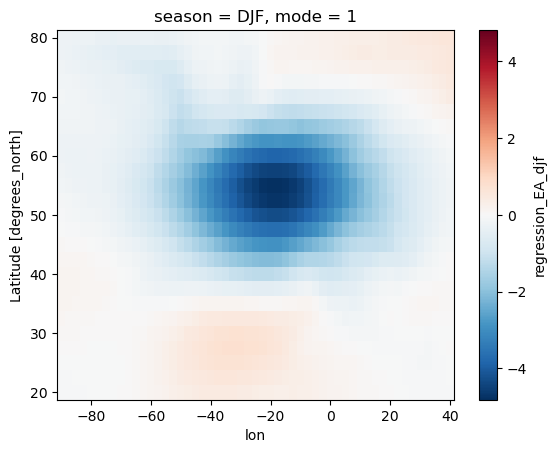

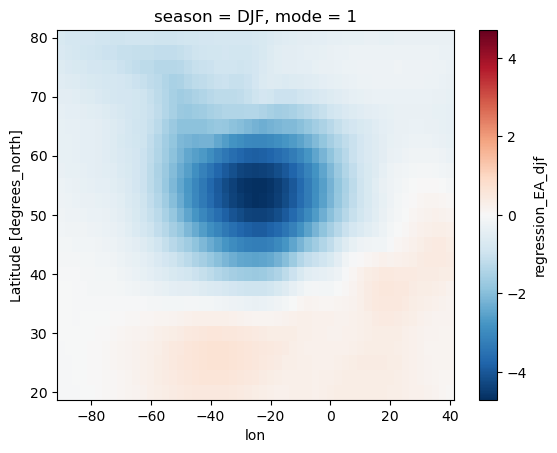

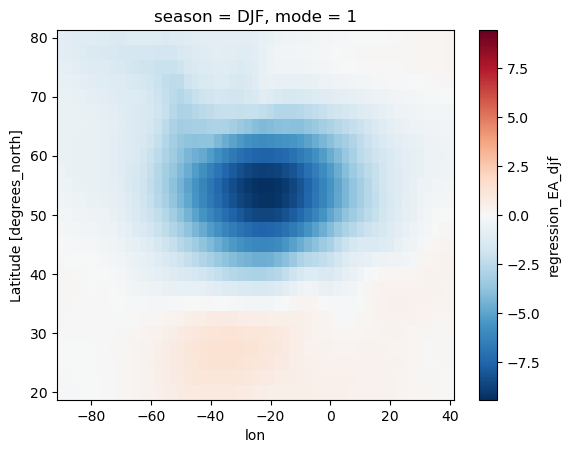

In [36]:
ds = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/EA/ensemble_members/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r12i1p1f3_DJF_EA_regression_map_1850-2015.nc')
ds['regression_EA_djf'].plot()
plt.show()
ds2 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/EA/psl_mon_historical_HadGEM3-GC31-LL_DJF_EA_regression_map_1850-2015.nc')
ds2['regression_EA_djf'].plot()
plt.show()
(ds['regression_EA_djf']+ds2['regression_EA_djf']).plot()
plt.show()

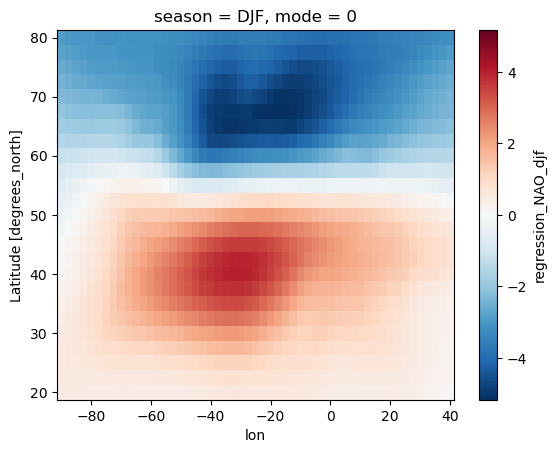

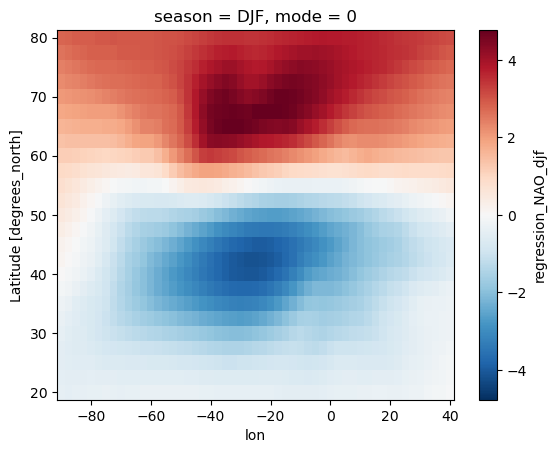

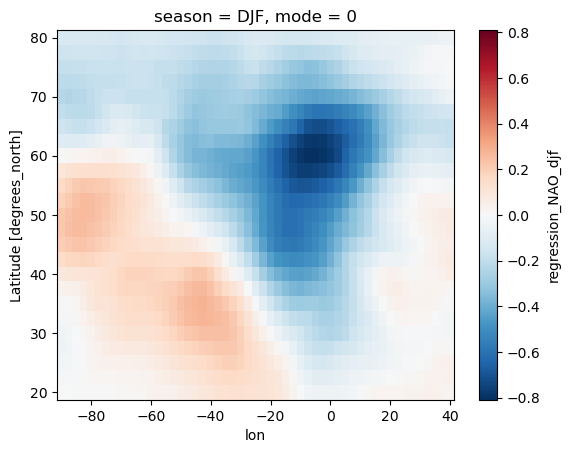

In [37]:
ds = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/ensemble_members/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r12i1p1f3_DJF_NAO_regression_map_1850-2015.nc')
ds['regression_NAO_djf'].plot()
plt.show()
ds2 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/psl_mon_historical_HadGEM3-GC31-LL_DJF_NAO_regression_map_1850-2015.nc')
ds2['regression_NAO_djf'].plot()
plt.show()
(ds['regression_NAO_djf']+ds2['regression_NAO_djf']).plot()
plt.show()

In [34]:
#notes find a way to update period so its nicer.
#also could fix folder so that I use like a home dir etc.
#anomalies have already been calculated separetly for each model so preusming they are all correct this should run?...
home = '/gws/nopw/j04/extant/users/slbennie/'


variable = 'psl'
period = '1850-2015'
experiments = ['historical', 'hist-aer', 'hist-GHG', 'hist-sol','hist-totalO3','hist-volc']
model = ['HadGEM3-GC31-LL']
modes = ['NAO', 'EA']
seas = 'DJF'

for m in model:
    #REGRESSION MAPS
    print('Calculating the regression map for model:', m)
    #path to the folder containing historical experiment and model's psl anomalies (calculated seperatley)
    folder_path = f'{home}psl_anomalies/historical/{m}/'

    #creating the list of files for this experiment and model's psl anomalies
    ens_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if m in filename and '_EM' not in filename]

    calculate_regression_map(ens_files, 'NAO', 'historical', m, period)
    calculate_regression_map(ens_files, 'EA', 'historical', m, period)

    #opening historical regression maps for use later - one per model. Use historical for all experiments.
    #regression_NAO = xr.open_dataset(home+'regression_patterns/NAO/'+variable+'_mon_historical_'+m+'_'+seas+'_NAO_regression_map_'+period+'.nc')
    #regression_EA = (xr.open_dataset(home+'regression_patterns/EA/'+variable+'_mon_historical_'+m+'_'+seas+'_EA_regression_map_'+period+'.nc'))

    
    #for e in experiments:
        #ENSEMBLE MEANS
    #    print('Calculating the spatial ensemble means and trends for model:', m)
    #    print('Experiment:', e)
        #getting the LESFMIP file paths
    #    folder_path = '/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/'+e+'/'+m+'/'
    #    file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if e in filename and m in filename]

        #creating output files for the mean across ensembles and the djf mean
    #    ens_mean_file = home+'ens_mean_spat/psl/'+e+'/'+m+'/'+variable+'_mon_'+e+'_'+m+'_spatial_EM.nc'
    #    ens_mean_djf_file = ens_mean_file.replace('spatial_EM', 'spatial_'+seas+'_EM_'+period)
        
        #find spatial mean across the ensembles
    #    print('Calculating the ensemble mean')
    #    calculate_spatial_ensemble_mean(file_paths, ens_mean_file, variable)

        #To use once spatial ensemble mean is calculated
    #    print('Calculating the seasonal '+seas+' spatial ensemble mean')
    #    calculate_seasonal_spatial_ensemble_mean_djf(ens_mean_file, variable, seas, ens_mean_djf_file, 1850, 2015)


        #LINEAR TREND
        #find the file for the ensemble spatial mean djf
    #    folder_path = home+'ens_mean_spat/psl/'+e+'/'+m+'/'

        #selecting file with the correct seas and period
    #    file_path = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if seas in filename and period in filename][0]
    #    print(file_path, ens_mean_djf_file)
    #    output_file = home+'trend_calc_LESFMIP/linear_regression/NAO/'+e+'/'+m+'/'+variable+'_mon_'+e+'_'+m+'_'+seas+'_linear_trend_'+period+'_stats.nc'
    
    #    calculate_linear_trend_spat_pattern(file_path, variable, output_file)


        #PROJECTION
    #    print("Calculating the projection of the forced trend onto historical regression map calculated from all ensembles:", e)
        
        #now setting up the folder path to get the file names for each experiment's model's forced response's trend
    #    folder_path = home+'trend_calc_LESFMIP/linear_regression/NAO/'+e+'/'+m+'/'
            
        #Getting the list of file names within the models folder, should only be one trend per model (working off the ensemble means for each model)
    #    ens_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if m in filename and period in filename]
    #    print(ens_files[0], len(ens_files), output_file)
            
    #    for i in range(0,len(ens_files)):
            #cropping each trend to just the NA sector and whichever time
    #        trend = open_cropNA_unitshPA(ens_files[i])#, 1850,2014)
    
            #multiplying the trend by 165 to convert to units of hPa (currently in units of hPa/year, trend calculated between 1850-2015)
    #        trend = trend * 165

    #        residual_NAO = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAtlantic_forced_trends/hist-aer/HadGEM3-GC31-LL/psl_mon_hist-aer_HadGEM3-GC31-LL_DJF_NAO_residual_1850-2015.nc')

            #calling the projection functions
            #proj_NAO, residual_NAO = project_onto_regression(trend, regression_NAO['regression_NAO_djf'], 'slope', 'NAO', e, m, period)
    #        proj_EA, residual_EA = project_onto_regression(residual_NAO, regression_EA['regression_EA_djf'], 'residual_NAO_djf', 'EA', e, m, period)
        

Calculating the projection of the forced trend onto historical regression map calculated from all ensembles: hist-aer
here
here


In [12]:
#notes find a way to update period so its nicer.
#also could fix folder so that I use like a home dir etc.
#anomalies have already been calculated separetly for each model so preusming they are all correct this should run?...
home = '/gws/nopw/j04/extant/users/slbennie/'


variable = 'psl'
period = '1850-2015'
experiment = ['historical', 'hist-aer', 'hist-GHG', 'hist-sol','hist-totalO3','hist-volc']
model = ['MIROC6']
modes = ['NAO', 'EA']
seas = 'DJF'

for e in experiment:
    print('Calculating the spatial ensemble means and trends for experiment e:', e)
    for m in model:
        print('Model: ',m)
        #getting the LESFMIP file paths
        folder_path = '/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/'+e+'/'+m+'/'
        file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if e in filename and m in filename]

        #creating output files for the mean across ensembles and the djf mean
        output_file = home+'ens_mean_spat/psl/'+e+'/'+m+'/'+variable+'_mon_'+e+'_'+m+'_spatial_EM.nc'
        output_file_djf = output_file.replace('spatial_EM', 'spatial_'+seas+'_EM_'+period)
        
        #find spatial mean across the ensembles
        print('Calculating the ensemble mean')
        calculate_spatial_ensemble_mean(file_paths, output_file, variable)

        #To use once spatial ensemble mean is calculated
        print('Calculating the seasonal '+seas+' spatial ensemble mean')
        calculate_seasonal_spatial_ensemble_mean_djf(output_file, variable, seas, output_file_djf, 1850, 2015)

        #find the file for the ensemble spatial mean djf
        folder_path = home+'ens_mean_spat/psl/'+e+'/'+m+'/'

        #choosing the djf/seas
        file_path = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if seas in filename and period in filename][0]
        output_file = home+'trend_calc_LESFMIP/linear_regression/NAO/'+e+'/'+m+'/'+variable+'_mon_'+e+'_'+m+'_'+seas+'_linear_trend_'+period+'_stats.nc'
    
        calculate_linear_trend_spat_pattern(file_path, variable, output_file)

#now creating the NAO and EA regression maps - just need historical!!
for m in model:
    #path to the folder containing historical experiment and model's psl anomalies (calculated seperatley)
    folder_path = f'{home}psl_anomalies/historical/{m}/'

    #creating the list of files for this experiment and model's psl anomalies
    ens_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if m in filename and '_EM' not in filename]

    calculate_regression_map(ens_files, trend, 'NAO', 'slope', 'historical', m, period)
    calculate_regression_map(ens_files, trend, 'EA', 'slope', 'historical', m, period)

#Now re-opening these maps and projecting the trends onto them
for m in model:
    print('Model:', m)
    regression_NAO = xr.open_dataset(home+'regression_patterns/NAO/'+variable+'_mon_historical_'+m+'_'+seas+'_NAO_regression_map_'+period+'.nc')
    regression_EA = xr.open_dataset(home+'regression_patterns/EA/'+variable+'_mon_historical_'+m+'_'+seas+'_EA_regression_map_'+period+'.nc')

    for e in experiment:
        print("Calculating the projection of the forced trend onto historical regression map calculated from all ensembles:", e)
        
        #now setting up the folder path to get the file names for each experiment's model's forced response's trend
        folder_path = home+'trend_calc_LESFMIP/linear_regression/NAO/'+e+'/'+m+'/'
            
        #Getting the list of file names within the models folder, should only be one trend per model (working off the ensemble means for each model)
        ens_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if m in filename and period in filename]
            
        for i in range(0,len(ens_files)):
            #cropping each trend to just the NA sector and whichever time
            trend = open_cropNA_unitshPA(ens_files[i])#, 1850,2014)
    
            #multiplying the trend by 165 to convert to units of hPa (currently in units of hPa/year, trend calculated between 1850-2015)
            trend = trend * 165

            #calling the projection functions
            proj_NAO, residual_NAO = project_onto_regression(trend, regression_NAO['regression_NAO_djf'], 'slope', 'NAO', e, m, period)
            proj_EA, residual_EA = project_onto_regression(residual_NAO, regression_EA['regression_EA_djf'], 'slope', 'EA', e, m, period)

#print(residual_NAO, residual_EA)

Calculating the spatial ensemble means and trends for experiment e: historical
Model:  MIROC6


NameError: name 'os' is not defined

In [13]:
home = '/gws/nopw/j04/extant/users/slbennie/'

variable = 'psl'
period = '1850-2015'
experiment = ['historical', 'hist-aer', 'hist-GHG', 'hist-sol','hist-totalO3','hist-volc']
model = ['MPI-ESM1-2-LR']
modes = ['NAO', 'EA']
seas = 'DJF'


#now creating the NAO and EA regression maps - just need historical!!
for m in model:
    #path to the folder containing historical experiment and model's psl anomalies (calculated seperatley)
    folder_path = f'{home}psl_anomalies/historical/{m}/'

    #creating the list of files for this experiment and model's psl anomalies
    ens_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if m in filename and '_EM' not in filename]

    calculate_regression_map(ens_files, 'NAO', 'historical', m, period)
    calculate_regression_map(ens_files, 'EA', 'historical', m, period)

#Now re-opening these maps and projecting the trends onto them
for m in model:
    print('Model:', m)
    regression_NAO = xr.open_dataset(home+'regression_patterns/NAO/'+variable+'_mon_historical_'+m+'_'+seas+'_NAO_regression_map_'+period+'.nc')
    regression_EA = xr.open_dataset(home+'regression_patterns/EA/'+variable+'_mon_historical_'+m+'_'+seas+'_EA_regression_map_'+period+'.nc')

    for e in experiment:
        print("Calculating the projection of the forced trend onto historical regression map calculated from all ensembles:", e)
        
        #now setting up the folder path to get the file names for each experiment's model's forced response's trend
        folder_path = home+'trend_calc_LESFMIP/linear_regression/NAO/'+e+'/'+m+'/'
            
        #Getting the list of file names within the models folder, should only be one trend per model (working off the ensemble means for each model)
        ens_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if m in filename and period in filename]
            
        for i in range(0,len(ens_files)):
            #cropping each trend to just the NA sector and whichever time
            trend = open_cropNA_unitshPA(ens_files[i])#, 1850,2014)
    
            #multiplying the trend by 165 to convert to units of hPa (currently in units of hPa/year, trend calculated between 1850-2015)
            trend = trend * 165

            #calling the projection functions
            proj_NAO, residual_NAO = project_onto_regression(trend, regression_NAO['regression_NAO_djf'], 'slope', 'NAO', e, m, period)
            proj_EA, residual_EA = project_onto_regression(residual_NAO, regression_EA['regression_EA_djf'], 'slope', 'EA', e, m, period)

#print(residual_NAO, residual_EA)

('ensemble', 'year', 'lat', 'lon')
('ensemble', 'year', 'lat', 'lon')
Model: MPI-ESM1-2-LR
Calculating the projection of the forced trend onto historical regression map calculated from all ensembles: historical
here
Calculating the projection of the forced trend onto historical regression map calculated from all ensembles: hist-aer
here
Calculating the projection of the forced trend onto historical regression map calculated from all ensembles: hist-GHG
here
Calculating the projection of the forced trend onto historical regression map calculated from all ensembles: hist-sol
here
Calculating the projection of the forced trend onto historical regression map calculated from all ensembles: hist-totalO3
here
Calculating the projection of the forced trend onto historical regression map calculated from all ensembles: hist-volc
here


In [16]:
#had to re-do these ones for the means.
home = '/gws/nopw/j04/extant/users/slbennie/'


variable = 'psl'
period = '1950-2015'
experiment = ['historical', 'hist-aer', 'hist-GHG', 'hist-sol']
model = ['CanESM5']
modes = ['NAO', 'EA']
seas = 'DJF'

for e in experiment:
    print('Calculating the spatial ensemble means and trends for experiment e:', e)
    for m in model:
        print('Model: ',m)
        #getting the LESFMIP file paths
        folder_path = '/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/'+e+'/'+m+'/'
        file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if e in filename and m in filename]

        #creating output files for the mean across ensembles and the djf mean
        output_file = home+'ens_mean_spat/psl/'+e+'/'+m+'/'+variable+'_mon_'+e+'_'+m+'_spatial_EM.nc'
        output_file_djf = output_file.replace('spatial_EM', 'spatial_'+seas+'_EM_'+period)
        
        #find spatial mean across the ensembles
        print('Calculating the ensemble mean')
        calculate_spatial_ensemble_mean(file_paths, output_file, variable)

        #To use once spatial ensemble mean is calculated
        print('Calculating the seasonal '+seas+' spatial ensemble mean')
        calculate_seasonal_spatial_ensemble_mean_djf(output_file, variable, seas, output_file_djf, 1850, 2015)

        #find the file for the ensemble spatial mean djf
        folder_path = home+'ens_mean_spat/psl/'+e+'/'+m+'/'
        file_path = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if seas in filename and period in filename][0]
        output_file = home+'trend_calc_LESFMIP/linear_regression/NAO/'+e+'/'+m+'/'+variable+'_mon_'+e+'_'+m+'_'+seas+'_linear_trend_'+period+'_stats.nc'
    
        calculate_linear_trend_spat_pattern(file_path, variable, output_file)


Calculating the spatial ensemble means and trends for experiment e: historical
Model:  CanESM5
Calculating the ensemble mean
saved
Calculating the seasonal DJF spatial ensemble mean
in function
saved file
Calculating the spatial ensemble means and trends for experiment e: hist-aer
Model:  CanESM5
Calculating the ensemble mean
saved
Calculating the seasonal DJF spatial ensemble mean
in function
saved file
Calculating the spatial ensemble means and trends for experiment e: hist-GHG
Model:  CanESM5
Calculating the ensemble mean
saved
Calculating the seasonal DJF spatial ensemble mean
in function
saved file
Calculating the spatial ensemble means and trends for experiment e: hist-sol
Model:  CanESM5
Calculating the ensemble mean
saved
Calculating the seasonal DJF spatial ensemble mean
in function
saved file


In [11]:
import xarray as xr
ds = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/NorESM2-LM/psl_mon_historical_NorESM2-LM_r10i1p1f1_DJF_anomaly.nc')


TypeError: 'numpy.ndarray' object is not callable

In [17]:
ds_r1 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/NorESM2-LM/psl_mon_historical_NorESM2-LM_r1i1p1f1_DJF_anomaly.nc')
ds_r10 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/NorESM2-LM/psl_mon_historical_NorESM2-LM_r10i1p1f1_DJF_anomaly.nc')

In [18]:
ds_r1

<xarray.Dataset> Size: 14MB
Dimensions:   (lat: 71, lon: 144, year: 165, bnds: 2)
Coordinates:
  * lat       (lat) float64 568B -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon       (lon) float64 1kB -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * year      (year) int64 1kB 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014
    season    <U3 12B ...
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 187kB ...
    lon_bnds  (year, lon, bnds) float64 380kB ...
    psl       (year, lat, lon) float64 13MB ...

In [19]:
ds_r10

<xarray.Dataset> Size: 15MB
Dimensions:   (lat: 71, lon: 144, year: 171, bnds: 2)
Coordinates:
  * lat       (lat) float64 568B -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon       (lon) float64 1kB -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * year      (year) int64 1kB 1850 1851 1852 1853 1854 ... 2017 2018 2019 2020
    season    <U3 12B ...
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 194kB ...
    lon_bnds  (year, lon, bnds) float64 394kB ...
    psl       (year, lat, lon) float64 14MB ...